# Lecture 7 - Student Notebook

In this exercises, you will compare the performance of different knowledge tracing models. We will use the same ASSISTments data set as for lecture 6.

The ASSISTments data sets are often used for benchmarking knowledge tracing models. We will play with a simplified data set that contains the following columns:

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| user_id | The ID of the student who is solving the problem.  | |
| order_id | The temporal ID (timestamp) associated with the student's answer to the problem.  | |
| skill_name | The name of the skill associated with the problem. | |
| correct | The student's performance on the problem: 1 if the problem's answer is correct at the first attempt, 0 otherwise. 

Note that this notebook will need to be run on a Tensorflow Kernel. If you have not done so, yet, do the following steps:
1. In your Noto, open a console. Click on `File > New Launcher > Other > Terminal`.
2. Run the following command: `kbuilder_create p_tf tensorflow`. This command will install a virtual environment `p_tf` for you.
3. Refresh the browser.
4. Change the kernel in the upper right corner of Noto. Select `p_tf`.

We first load the data set.

In [1]:
# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, roc_auc_score

# PyBKT package imports
from pyBKT.models import Model
# Import the lmm model class
from pymer4.models import Lmer

# Tensorflow
import tensorflow as tf

DATA_DIR = "./../data/"

2022-04-04 10:32:44.206829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-04 10:32:44.206940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
assistments = pd.read_csv(DATA_DIR + 'assistments.csv', low_memory=False).dropna()
assistments.head()

,user_id,order_id,skill_name,correct
0,64525,33022537,Box and Whisker,1
1,64525,33022709,Box and Whisker,1
2,70363,35450204,Box and Whisker,0
3,70363,35450295,Box and Whisker,1
4,70363,35450311,Box and Whisker,0


Next, we print the number of unique students and skills in this data set.

In [3]:
print("Number of unique students in the dataset:", len(set(assistments['user_id'])))
print("Number of unique skills in the dataset:", len(set(assistments['skill_name'])))

Number of unique students in the dataset: 4151
Number of unique skills in the dataset: 110


We also implement a utility function that splits the data in two folds, making sure that all interactions of a student land in the same fold. We will use this function to obtain train, test, and validation folds of our data.

In [4]:
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''    
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index)) 
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values 
    return model_selection.GroupShuffleSplit(n_splits=1, train_size=.8, test_size=0.2, random_state=0).split(X, groups=groups)

## Additive Factors Model (AFM) and Performance Factors Analysis (PFA)

The AFM and PFA models are both based on logistic regression and item response theory (IRT). Specifically, they compute the probability that a student will solve a task correctly based on the number of previous attempts the student had at the corresponding skill (in case of AFM) and based on the correct and wrong attempts at the corresponding skill (in case of PFA), respectively. We therefore first preprocess the data to compute these variables. For demonstration purposes, we will continue on the small subset of the data set containing six skills.

In [5]:
skills_subset = ['Circle Graph', 'Venn Diagram', 'Mode', 'Division Fractions', 'Finding Percents', 'Area Rectangle']
data = assistments[assistments['skill_name'].isin(skills_subset)]

print("Skill set:", set(data['skill_name']))
print("Number of unique students in the subset:", len(set(data['user_id'])))
print("Number of unique skills in the subset:", len(set(data['skill_name'])))

Skill set: {'Division Fractions', 'Finding Percents', 'Mode', 'Circle Graph', 'Venn Diagram', 'Area Rectangle'}
Number of unique students in the subset: 1527
Number of unique skills in the subset: 6


In [6]:
# Data processing
# Number of attempts before current
def preprocess_data(data):
    data['aux'] = 1
    data['prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['aux'].cumsum() -1

    # Number of correct and incorrect attempts before current attempt
    data['correct_aux'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct'].cumsum()
    data['before_correct_num'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['correct_aux'].shift(periods=1, fill_value=0)
    data['before_wrong_num'] = data['prev_attempts'] - data['before_correct_num']
    return data

data = preprocess_data(data)
data.head()

/tmp/ipykernel_870/1740239184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['aux'] = 1
/tmp/ipykernel_870/1740239184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_name'])['aux'].cumsum() -1
/tmp/ipykernel_870/1740239184.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
3957,14,21617623,Circle Graph,0,1,0,0,0,0
3958,14,21617632,Circle Graph,1,1,1,1,0,1
3959,14,21617641,Circle Graph,0,1,2,1,1,1
3960,14,21617650,Circle Graph,0,1,3,1,1,2
3961,14,21617659,Circle Graph,0,1,4,1,1,3


Next, we split the data into a training and a test data set.

In [7]:
# Obtain indexes
train_index, test_index = next(create_iterator(data))
# Split the data
X_train, X_test = data.iloc[train_index], data.iloc[test_index]

Next, we fit an AFM model to the training data and predict on the test data. Note that the implementation below only works for a one-to-one correspondance of task and skill, i.e. when a task is associated to exactly one skill. In case of a data set containing tasks with multiple skills, we would need to use the [pyAFM](https://github.com/cmaclell/pyAFM) package. A tutorial on using pyAFM can be found [here](https://github.com/epfl-ml4ed/mlbd-2021/tree/main/Tutorials/Tutorial06/Tutorial06).

In [8]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + prev_attempts|skill_name)", data=X_train, family='binomial')
%time model.fit() 
# Compute predictions
X_test['afm_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+prev_attempts|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16797.782 	 AIC: 33603.565

Random effects:

                       Name     Var     Std
user_id         (Intercept) 2.56000 1.60000
skill_name      (Intercept) 0.68300 0.82700
skill_name.1  prev_attempts 0.00500 0.06900

No random effect correlations specified

Fixed effects:

CPU times: user 44.9 s, sys: 457 ms, total: 45.3 s
Wall time: 2min 6s


/tmp/ipykernel_870/736728277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['afm_predictions'] = model.predict(data=X_test, verify_predictions=False)


,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions
3969,64525,28186893,Circle Graph,1,1,0,1,0,0,0.48266
3970,64525,28187093,Circle Graph,1,1,1,2,1,0,0.49251
3971,64525,32413158,Circle Graph,1,1,2,3,2,0,0.50236
3972,64525,33022751,Circle Graph,0,1,3,3,3,0,0.51221
3973,64525,33023039,Circle Graph,1,1,4,4,3,1,0.52205


Next, we fit a PFA model to the data. Again, this implementation works for one-to-one correspondance and tasks with multiple skills would require the use of [pyAFM](https://github.com/cmaclell/pyAFM).

In [9]:
# Initialize and fit the model
model = Lmer("correct ~ (1|user_id) + (1|skill_name) + (0 + before_correct_num|skill_name) + (0 + before_wrong_num|skill_name)", data=X_train, family='binomial')
%time model.fit() 
# Compute predictions
X_test['pfa_predictions'] = model.predict(data=X_test, verify_predictions=False)
X_test.head()

Formula: correct~(1|user_id)+(1|skill_name)+(0+before_correct_num|skill_name)+(0+before_wrong_num|skill_name)

Family: binomial	 Inference: parametric

Number of observations: 40258	 Groups: {'user_id': 1221.0, 'skill_name': 6.0}

Log-likelihood: -16385.969 	 AIC: 32781.939

Random effects:

                            Name     Var     Std
user_id              (Intercept) 1.74800 1.32200
skill_name           (Intercept) 0.69900 0.83600
skill_name.1  before_correct_num 0.02600 0.16200
skill_name.2    before_wrong_num 0.00000 0.01000

No random effect correlations specified

Fixed effects:

CPU times: user 2min 31s, sys: 2.24 s, total: 2min 34s
Wall time: 16min 8s


/tmp/ipykernel_870/1100232259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pfa_predictions'] = model.predict(data=X_test, verify_predictions=False)


,user_id,order_id,skill_name,correct,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions
3969,64525,28186893,Circle Graph,1,1,0,1,0,0,0.48266,0.46224
3970,64525,28187093,Circle Graph,1,1,1,2,1,0,0.49251,0.48999
3971,64525,32413158,Circle Graph,1,1,2,3,2,0,0.50236,0.51780
3972,64525,33022751,Circle Graph,0,1,3,3,3,0,0.51221,0.54551
3973,64525,33023039,Circle Graph,1,1,4,4,3,1,0.52205,0.54598


## Deep Knowledge Tracing (DKT)

Knowledge tracing is one of the key research areas for empowering personalized education. It is a task to model students' mastery level of a skill based on their historical learning trajectories. In recent years, a recurrent neural network model called deep knowledge tracing (DKT) has been proposed to handle the knowledge tracing task and literature has shown that DKT generally outperforms traditional methods.

Next, we will create and evaluate DKT models on top of a TensorFlow framework. For those who are not familiar with this framework, we recommended to follow the [official tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner). 

We continue to work with the small subset (six skills of the data). Furthermore, we will continue to use the same train test split as before.

### Data preparation
A DKT model is characterized by the following main three components:
- **Input**: the one-hot encoded observations at varying time steps. 
- **Network**: a recurrent neural network that processes the one-hot encoded observations in a time-wise manner. 
- **Output**: the probabilities for answering skill (or item) correct at the varying time steps.  

The first step to enable a DKT experimental pipeline requires to prepare the input and output data to be fed into the model during the training and evaluation phases. TensorFlow has an API, called [TF Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), that supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern: (i) create a source dataset from your input data, (ii) apply dataset transformations to preprocess the data, (iii) iterate over the dataset and process the elements. Iteration happens in a streaming fashion, so the full dataset does not need to fit into memory.

In [10]:
def prepare_seq(df):
    # Step 1 - Enumerate skill id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4- Get max skill depth and max feature depth
    skill_depth = df['skill'].max() 
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth

In [11]:
def prepare_data(seq, params, features_depth, skill_depth):
    
    # Step 1 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq)

The data needs to be fed into the model in batches. Therefore, we need to specify in advance how many elements per batch our DKT will receive. Furthermore, all sequences should be of the same length in order to be fed into the model. Given that students have different number of opportunities across skills, we need to define a masking value for those entries that are introduced as a padding into the student's sequences.

In [12]:
params = {}
params['batch_size'] = 32
params['mask_value'] = -1.0

We are now ready to encode the data and split into a training, validation, and test set.

In [13]:
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

seq, features_depth, skill_depth = prepare_seq(data)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)

params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

/tmp/ipykernel_870/2886616435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)
/tmp/ipykernel_870/2886616435.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['skill_with_answer'] = df['skill'] * 2 + df['correct']
2022-04-03 23:10:02.762738: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2

### Model Creation

Next, we create and compile the model. To do so, we first define the necessary parameters.

In [14]:
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

Considering that we padded the sequences such that all have the same length, we need to remove predictions on the time step associated with padding. We also need to mach each output with a specific skill.
To this end, we implement a function calle get_target. 

In [15]:
def get_target(y_true, y_pred, mask_value=params['mask_value']):
    
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

While training the model, we will monitor the following evaluation metrics.

In [16]:
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        
def CustomBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)   

We are not ready to create the model.

In [17]:
def create_model(nb_features, nb_skills, params):
    
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'])(inputs)
    x = tf.keras.layers.SimpleRNN(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), RMSE()])
    
    return model

model = create_model(features_depth, skill_depth, params)

In [18]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 12)]        0         
                                                                 
 masking (Masking)           (None, None, 12)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          464       
                                                                 
 outputs (TimeDistributed)   (None, None, 5)           85        
                                                                 
Total params: 549
Trainable params: 549
Non-trainable params: 0
_________________________________________________________________


### Model Fitting and Evaluation

Finally, we fit the model on the training data and evaluate it on the test data.
We are using a callback for the model, i.e. we store the best model (on the validation set) and then use this model for prediction.

In [19]:
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size']-1, 
                    validation_data=tf_val,  validation_steps = params['val_size'], 
                    callbacks=[ckp_callback], verbose=params['verbose'])

Epoch 1/10
37/37 [==============================] - 146s 2s/step - loss: 0.8859 - auc: 0.4287 - root_mean_squared_error: 0.6880 - val_loss: 0.8559 - val_auc: 0.4649 - val_root_mean_squared_error: 0.6788
Epoch 2/10
37/37 [==============================] - 44s 1s/step - loss: 0.8780 - auc: 0.4663 - root_mean_squared_error: 0.6736 - val_loss: 0.8486 - val_auc: 0.5010 - val_root_mean_squared_error: 0.6684
Epoch 3/10
37/37 [==============================] - 23s 622ms/step - loss: 0.8707 - auc: 0.5006 - root_mean_squared_error: 0.6633 - val_loss: 0.8436 - val_auc: 0.5392 - val_root_mean_squared_error: 0.6605
Epoch 4/10
37/37 [==============================] - 43s 1s/step - loss: 0.8630 - auc: 0.5283 - root_mean_squared_error: 0.6549 - val_loss: 0.8399 - val_auc: 0.5540 - val_root_mean_squared_error: 0.6542
Epoch 5/10
37/37 [==============================] - 45s 1s/step - loss: 0.8636 - auc: 0.5458 - root_mean_squared_error: 0.6487 - val_loss: 0.8369 - val_auc: 0.5657 - val_root_mean_squared_

We evaluate on the test data set and print the results.

In [20]:
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

9/9 [==============================] - 2s 147ms/step - loss: 0.6257 - auc: 0.6489 - root_mean_squared_error: 0.5970


In [21]:
# Binary cross entropy, AUC, RMSE
metrics_dkt_small

[0.6257227659225464, 0.6488946676254272, 0.5970044136047363]

## BKT

We first also fit a BKT model to this data set using the same train/test split as above.

In [22]:
df_preds = pd.DataFrame()

# Train a BKT model for each skill
for skill in skills_subset:
    print("--{}--".format(skill))
    X_train_skill = X_train[X_train['skill_name'] == skill]
    X_test_skill = X_test[X_test['skill_name'] == skill]
    # Initialize and fit the model
    model = Model(seed=0)
    %time model.fit(data=X_train_skill) 
    preds = model.predict(data=X_test_skill) [['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'correct_predictions']]
    df_preds = df_preds.append(preds)

X_test = df_preds
X_test.columns = ['user_id', 'order_id', 'skill_name', 'correct', 'prev_attempts',
       'before_correct_num', 'before_wrong_num', 'afm_predictions', 'pfa_predictions', 'bkt_predictions']
X_test.head()

--Circle Graph--
CPU times: user 7.25 s, sys: 0 ns, total: 7.25 s
Wall time: 12.5 s
--Venn Diagram--
CPU times: user 5.04 s, sys: 0 ns, total: 5.04 s
Wall time: 6.67 s
--Mode--
CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 2.14 s
--Division Fractions--
CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.6 s
--Finding Percents--
CPU times: user 3.99 s, sys: 0 ns, total: 3.99 s
Wall time: 4.8 s
--Area Rectangle--
CPU times: user 3.4 s, sys: 84.8 ms, total: 3.48 s
Wall time: 4.7 s


,user_id,order_id,skill_name,correct,prev_attempts,before_correct_num,before_wrong_num,afm_predictions,pfa_predictions,bkt_predictions
3969,64525,28186893,Circle Graph,1,0,0,0,0.48266,0.46224,0.45017
3970,64525,28187093,Circle Graph,1,1,1,0,0.49251,0.48999,0.63177
3971,64525,32413158,Circle Graph,1,2,2,0,0.50236,0.51780,0.68849
3972,64525,33022751,Circle Graph,0,3,3,0,0.51221,0.54551,0.70007
3973,64525,33023039,Circle Graph,1,4,3,1,0.52205,0.54598,0.69556


In [23]:
X_test.to_csv('x_test_07.csv.gz', compression = 'gzip', index = False)

# Your Turn 1 - Model Comparison on Subset

Up to now, we have compared model performance on a subset of the data. Your task is to compare and discuss performance of the different models:
1. Visualize the overall RMSE and AUC of the four models (AFM, PFA, BKT, DKT) such that the metrics can be easily compared.
2. Interpret your results and discuss your observations.

In [1]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-07',
    'session_owner': 'mlbd-2022',
    'sender_name': input("Your name: "),
}

In [24]:
# If it is taking too long to run, you may load our X_test to compute the RMSE and AUC
X_test = pd.read_csv('x_test_07.csv.gz', compression = 'gzip')

In [ ]:
# Visualize plots

send(plt, 1)
plt.show()

In [ ]:
interpretation = """
Write your interpretation here
"""

send(interpretation, 2)

# Your Turn 2 - Model Comparison on Full Data Set

Finally, we compare predictive performance of the models on the full data set. We only compare BKT (the previously best model) and DKT. Below you find the overall RMSE and AUC on of BKT and DKT on the full data set:
1. Which model is doing a better? Discuss your observations.
2. Are the results different from the results on the subset of the data. If yes, why?

Text(0, 0.5, 'RMSE')

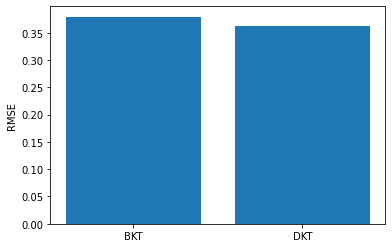

In [5]:
# Results from demo notebook
rmse = [0.37921100290974447, 0.36206743121147156]
models = ['BKT', 'DKT']

plt.bar(models, rmse)
plt.ylabel('RMSE')

Text(0, 0.5, 'AUC')

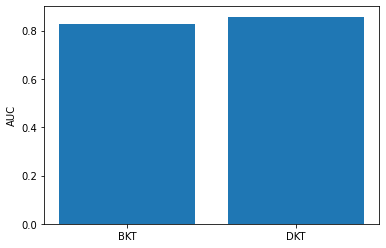

In [4]:
# Results from demo notebook
auc = [0.8253168302396643, 0.8575211763381958]
models = ['BKT', 'DKT']

plt.bar(models, auc)
plt.ylabel('AUC')

In [ ]:
interpretation = """
Which model is doing a better? Discuss your observations.
"""

send(interpretation, 3)

In [ ]:
interpretation = """
Are the results different from the results on the subset of the data. If yes, why?
"""

send(interpretation, 4)